<a href="https://colab.research.google.com/github/Allenchou0708/360VR_CAC/blob/main/360VR_Image_CAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
dropbox_url = "https://www.dropbox.com/scl/fi/acmqku4epcyfcsemgudp7/360-Dataset.zip?rlkey=7drolyxn91cym4hicrj5wru73&e=2&st=netdigwb&dl=0"
output_zip_filename = "360-Dataset.zip"
extract_folder = "360-Dataset"

!wget -O "{output_zip_filename}" "{dropbox_url}"

!unzip -q -o "{output_zip_filename}" -d "{extract_folder}"


--2025-07-01 01:16:59--  https://www.dropbox.com/scl/fi/acmqku4epcyfcsemgudp7/360-Dataset.zip?rlkey=7drolyxn91cym4hicrj5wru73&e=2&st=netdigwb&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc822fc2b8072db6f4bbac6af892.dl.dropboxusercontent.com/cd/0/inline/CsoaciXrjMgt_MWXMdnKxUghy4kD44cWd594VNGWlRO_soJ0Sc7igFolB3ILLMEyFEOv5pv0ZcYbTzl4kOjMscKRt6PLjV8GbQiU5kgqwHs5scFAw9uSGmEDSRzcGlI5Lho/file# [following]
--2025-07-01 01:17:00--  https://uc822fc2b8072db6f4bbac6af892.dl.dropboxusercontent.com/cd/0/inline/CsoaciXrjMgt_MWXMdnKxUghy4kD44cWd594VNGWlRO_soJ0Sc7igFolB3ILLMEyFEOv5pv0ZcYbTzl4kOjMscKRt6PLjV8GbQiU5kgqwHs5scFAw9uSGmEDSRzcGlI5Lho/file
Resolving uc822fc2b8072db6f4bbac6af892.dl.dropboxusercontent.com (uc822fc2b8072db6f4bbac6af892.dl.dropboxusercontent.com)... 162.125.13.15, 2620:100:601c:15::a27d:

In [2]:
import argparse
from math import pi, atan, cos, sin, acos, sqrt, tan
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import sys
from scipy.interpolate import RectBivariateSpline

In [3]:
CF_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4
INPUT_RESOLUTION = (416, 416)

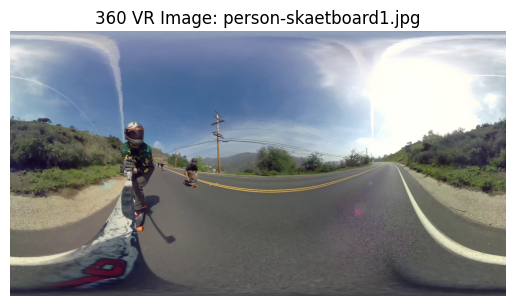

In [4]:
pano_picture = "./360-Dataset/360-Dataset/images/person-skaetboard1.jpg"
result_picture = "."

# ls 360-Dataset/360-Dataset/images

img = Image.open(pano_picture)

plt.imshow(img)
plt.title("360 VR Image: person-skaetboard1.jpg")
plt.axis('off')
plt.show()

In [44]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.interpolate import RectBivariateSpline


def tangent_projection(penorama_pic_name, lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg, need_density_map = False, p_prime = []): # "fake_era.jpg", 中心緯度, 中心經度


  input_image = Image.open(penorama_pic_name).convert("RGB") # 確保一定是 rgb
  input_array = np.array(input_image)
  H, W, _ = input_array.shape

  # 球參數
  R = 1

  interp_0 = RectBivariateSpline(np.arange(H), np.arange(W), input_array[:, :, 0])
  interp_1 = RectBivariateSpline(np.arange(H), np.arange(W), input_array[:, :, 1])
  interp_2 = RectBivariateSpline(np.arange(H), np.arange(W), input_array[:, :, 2])

  # 中心點 (15N, 15E)
  lat0 = np.radians((lat_min_deg + lat_max_deg) / 2)
  lon0 = np.radians((lon_min_deg + lon_max_deg) / 2)
  P0 = np.array([
      R * np.cos(lat0) * np.cos(lon0),
      R * np.cos(lat0) * np.sin(lon0),
      R * np.sin(lat0)
  ])

  # === 建立平面座標格 ===
  # 建立一個平面方格範圍 (2D)，中心為 P0
  grid_size = 300  # 輸出的平面圖像大小
  extent = 0.5  # 平面大小 (單位球下)

  # 定義平面基底向量：e1, e2 與 normal 垂直，一個平面可以表示成一點兩平面向量
  normal = P0 / np.linalg.norm(P0) # two norm
  up = np.array([0, 0, 1])
  e1 = np.cross(up, normal)
  if np.linalg.norm(e1) < 1e-5:
      e1 = np.cross([1, 0, 0], normal)
  e1 = e1 / np.linalg.norm(e1)
  e2 = np.cross(normal, e1)

  # 建立平面網格
  u_vals = np.linspace(-extent, extent, grid_size) #含頭含尾切成 grid_size 等分
  v_vals = np.linspace(-extent, extent, grid_size) #含頭含尾切成 grid_size 等分
  uu, vv = np.meshgrid(u_vals, v_vals) # 每一對 (uu[i, j], vv[i, j]) 是平面上的一個 2D 點。
  plane_points = P0[None, None, :] + uu[..., None]*e1 + vv[..., None]*e2

  # === 射線與球面交點 ===
  # 射線：從平面點往球心方向投影
  ray_dir = -plane_points  # (H, W, 3) (平面寬, 平面長, (x, y, z)) #關於原點對稱
  ray_dir = ray_dir / np.linalg.norm(ray_dir, axis=-1, keepdims=True)

  # 求交點（只取較靠近平面的那個）
  a = np.sum(ray_dir**2, axis=-1) #(H, W, 1)，每一個元素都是 1
  b = 2 * np.sum(ray_dir * plane_points, axis=-1)
  c = np.sum(plane_points**2, axis=-1) - R**2
  discriminant = b**2 - 4*a*c
  t = (-b - np.sqrt(np.clip(discriminant, 0, None))) / (2*a)

  # 只保留能與球相交的點
  mask = discriminant >= 0
  intersection = plane_points + ray_dir * t[..., None]





  # === 球面點 → (lat, lon) ===
  x, y, z = intersection[..., 0], intersection[..., 1], intersection[..., 2]
  lat = np.arcsin(z / R)
  lon = np.arctan2(y, x)

  # 弧度轉成度
  lat_deg = np.degrees(lat)
  lon_deg = np.degrees(lon) % 360

  # 建立最終圖像（初始化黑色）
  projected_img = np.zeros((grid_size, grid_size, 3), dtype=np.uint8)

  # 遮罩：只保留 lat ∈ [0, 30], lon ∈ [0, 30]
  valid_mask = (
      mask &
      (lat_deg >= lat_min_deg) & (lat_deg <= lat_max_deg) &
      (lon_deg >= lon_min_deg) & (lon_deg <= lon_max_deg)
  ) # (H, W, 3)

  # 對應到 ERA 的像素座標
  x_img = (lon_deg / 360.0 * W)
  y_img = ((90 - lat_deg) / 180.0 * H)
  x_valid = x_img[valid_mask]
  y_valid = y_img[valid_mask]

  i_valid, j_valid = np.where(valid_mask)

  # 填入對應顏色
  projected_img[i_valid, j_valid, 0] = np.clip(interp_0.ev(y_valid, x_valid), 0, 255)
  projected_img[i_valid, j_valid, 1] = np.clip(interp_1.ev(y_valid, x_valid), 0, 255)
  projected_img[i_valid, j_valid, 2] = np.clip(interp_2.ev(y_valid, x_valid), 0, 255)


  if need_density_map:

    density_img = np.zeros((grid_size, grid_size), dtype=np.uint8)

    # p'
    # x'
    x_prime = intersection.reshape(-1, 3)  # (HW, 3)
    p_prime = np.array(p_prime)           # (N, 3)


    distances = cdist(x_prime, p_prime)   # (HW, N)

    sigma = 0.05  # 調整模糊程度，與球面尺度有關
    weights = np.exp(-0.5 * (distances**2) / sigma**2)
    density = np.sum(weights, axis=1)



    density_map = density.reshape(grid_size, grid_size)
    density_map = (density_map / np.max(density_map) * 255).astype(np.uint8) # 正規化

    density_img[valid_mask] = density_map[valid_mask]

    # print(f"density size = {density.shape}")
    # print(f"density_map size = {density_map.shape}")

    return projected_img, density_img

  else :
    return projected_img

# projected_img = tangent_projection("fake_era.jpg", 0, 30, 0, 30)

# # === 顯示結果 ===
# plt.figure(figsize=(8, 8))
# plt.imshow(projected_img[::-1]) # 第一個維度反轉
# plt.title("Projected Sphere Region (0°–30° N, 0°–30° E) to Tangent Plane")
# plt.axis('off')
# plt.show()


In [47]:


def pano_tangent_projection(penorama_pic_name, w_space, h_space, need_density_map = False, p_prime = []): # 30, -30


  longitudes = np.arange(0, 360, w_space)
  latitudes = np.arange(90, -90, h_space)


  projected_images = []
  density_maps = []


  rownum = len(latitudes)
  colnum = len(longitudes)



  for lat_max_deg in latitudes:
    for lon_min_deg in longitudes:

      lat_min_deg = lat_max_deg + h_space
      lon_max_deg = lon_min_deg + w_space

      if need_density_map :
        projected_img, density_map = tangent_projection(penorama_pic_name, lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg, need_density_map, p_prime)
        density_maps.append(density_map)
      else :
        projected_img = tangent_projection(penorama_pic_name, lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg)

      projected_images.append(projected_img)
      # return projected_images, rownum, colnum, density_maps

  if need_density_map :
    return projected_images, rownum, colnum, density_maps

  else:

    return projected_images, rownum, colnum



In [ ]:
tree = ET.parse(f"./360-Dataset/360-Dataset/bfov-annotations/l-{sample_images}.xml")
root = tree.getroot()

for obj in root.findall('object'):

  cat = obj.find("name").text

  bndbox = obj.find('ThreeDbox')

  lat_min_arc = min(float(bndbox.find('bl_lat').text),float(bndbox.find('br_lat').text))
  lat_max_arc = max(float(bndbox.find('tl_lat').text),float(bndbox.find('tr_lat').text))
  lon_min_arc = min(float(bndbox.find('tl_lon').text),float(bndbox.find('bl_lon').text))
  lon_max_arc = max(float(bndbox.find('tr_lon').text),float(bndbox.find('br_lon').text))

  lat_min_arc_std = (np.pi / 2) - lat_min_arc #換成赤道緯度
  lat_max_arc_std = (np.pi / 2) - lat_max_arc #換成赤道緯度


  lat_min_deg = np.degrees(lat_min_arc_std)
  lat_max_deg = np.degrees(lat_max_arc_std)
  lon_min_deg = np.degrees(lon_min_arc) % 360
  lon_max_deg = np.degrees(lon_max_arc) % 360

  print((lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg))


  projected_img = tangent_projection(f"./360-Dataset/360-Dataset/images/{sample_images}.jpg", lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg)
  plt.figure(figsize=(8, 8))
  plt.imshow(projected_img[::-1]) # 第一個維度反轉
  plt.title(f"{cat}")
  plt.axis('off')
  plt.show()

  # 生成 cat2refnum dict

  # if cat in cat2refnum:
  #   cat2refnum[cat].append(ref_num)
  # else:
  #   cat2refnum[cat] = [ref_num]

  # ref_num += 1

  # # tangent projection 出 refference image


# save image cv2.write() in [cat]/str(ref_num)

In [6]:
import glob
import os

image_paths = glob.glob('./360-Dataset/360-Dataset/images/*.jpg')
# 列出所有符合該條件的路徑 ex ./360-Dataset/360-Dataset/images/image1870.jpg

imgkey = []

for path in image_paths:
    filename = os.path.basename(path)
    name_only = os.path.splitext(filename)[0]  # 去掉副檔名
    imgkey.append(name_only)

print(imgkey[:10])
print(f"# of panorama : {len(imgkey)}")

['person-florida2395', 'sandboard45', 'image720', 'penguins2345', 'person-sea4185', 'image2170', '6681', 'person-florida3840', 'person-florida950', 'sandboard175']
# of panorama : 903


In [73]:
import xml.etree.ElementTree as ET
from collections import Counter
import pickle
import os
from tqdm import tqdm
from collections import defaultdict


def gen_query_images(imgkeys, data_path):

  cat2imgkey = {}

  for imgkey in tqdm(imgkeys):

    tree = ET.parse(f"./360-Dataset/360-Dataset/bfov-annotations/l-{imgkey}.xml")
    root = tree.getroot()

    # 訂定 panorama 的 category
    category_list = []

    for obj in root.findall('object'):
        category = obj.find('name').text
        category_list.append(category)

    counter = Counter(category_list)
    max_count = max(counter.values())

    if max_count > 3 : # query 只選有五個以上的
      modes = [k for k, v in counter.items() if v == max_count]
      selected_cat = modes[0]

      query_cats_path =  os.path.join(data_path, f"query_images/{selected_cat}")

      if not os.path.exists(query_cats_path):
        os.makedirs(query_cats_path)

      query_images_path =  os.path.join(data_path, f"query_images/{selected_cat}/{imgkey}")

      if not os.path.exists(query_images_path):
        os.makedirs(query_images_path)

      density_maps_path =  os.path.join(data_path, f"density_maps/{selected_cat}/{imgkey}")

      if not os.path.exists(density_maps_path):
        os.makedirs(density_maps_path)




      # cat2imgkey

      if selected_cat in cat2imgkey:
          cat2imgkey[selected_cat].append(imgkey)
      else:
          cat2imgkey[selected_cat] = [imgkey]


      # p'
      p_prime = []
      for obj in root.findall('object'):
        category = obj.find('name').text
        if category == selected_cat :
          bndbox = obj.find('BFOV')
          center_lon = float(bndbox.find('center_lon').text)
          center_lat = float(bndbox.find('center_lat').text)



          x = np.sin(center_lat) * np.cos(center_lon)
          y = np.sin(center_lat) * np.sin(center_lon)
          z = np.cos(center_lat)
          p_prime.append([x, y, z])



      projected_images, rownum, colnum, density_maps = pano_tangent_projection(f"./360-Dataset/360-Dataset/images/{imgkey}.jpg", 45, -45, True, p_prime)


      for query_num, projected_image in enumerate(projected_images):      # save image cv2.write() in [cat]/str(ref_num)
        img_bgr = cv2.cvtColor(projected_image[::-1], cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(query_images_path,f'{query_num}.png'), img_bgr)

      for query_num, density_map in enumerate(density_maps):      # save image cv2.write() in [cat]/str(ref_num)
        cv2.imwrite(os.path.join(density_maps_path,f'{query_num}.png'), density_map[::-1])

  with open(os.path.join(data_path,'cat2imgkey.pkl'), 'wb') as f:
    pickle.dump(cat2imgkey, f)

  return cat2imgkey





def gen_refference_images(imgkeys, cat2imgkey, data_path):

    cat2refnum = {}
    threshold = 30

    catrefnum2scat = {}
    category_counter = defaultdict(int)



    for cat, imgkey_list in cat2imgkey.items():

      for imgkey in tqdm(imgkey_list) :
        tree = ET.parse(f"./360-Dataset/360-Dataset/bfov-annotations/l-{imgkey}.xml")
        root = tree.getroot()

        for obj in root.findall('object'):

          # 生成 cat2refnum dict

          category = obj.find('name').text


          bndbox = obj.find('ThreeDbox')

          lat_min_arc = min(float(bndbox.find('bl_lat').text),float(bndbox.find('br_lat').text))
          lat_max_arc = max(float(bndbox.find('tl_lat').text),float(bndbox.find('tr_lat').text))
          lon_min_arc = min(float(bndbox.find('tl_lon').text),float(bndbox.find('bl_lon').text))
          lon_max_arc = max(float(bndbox.find('tr_lon').text),float(bndbox.find('br_lon').text))

          lat_min_arc_std = (np.pi / 2) - lat_min_arc #換成赤道緯度
          lat_max_arc_std = (np.pi / 2) - lat_max_arc #換成赤道緯度


          lat_min_deg = np.degrees(lat_min_arc_std)
          lat_max_deg = np.degrees(lat_max_arc_std)
          lon_min_deg = np.degrees(lon_min_arc) % 360
          lon_max_deg = np.degrees(lon_max_arc) % 360

          # tangent projection 出 refference image

          projected_img = tangent_projection(f"./360-Dataset/360-Dataset/images/{imgkey}.jpg", lat_min_deg, lat_max_deg, lon_min_deg, lon_max_deg)

          ## 黑色的部分還是太多了，是否可以自動調整 scale
          ## 如果亮點不足 threshold * threshold，則放棄
          nonzero_pixels = np.sum(np.any(projected_img != 0, axis=-1))

          if nonzero_pixels < threshold * threshold:
            continue


          refference_images_path = os.path.join(data_path,f"refference_images/{category}")

          if not os.path.exists(refference_images_path):
            os.makedirs(refference_images_path)

          ref_num = category_counter[category]


          # save image cv2.write() in [cat]/str(ref_num)
          img_bgr = cv2.cvtColor(projected_img[::-1], cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(refference_images_path,f'{ref_num}.png'),img_bgr)

          if category in cat2refnum:
            cat2refnum[category].append(ref_num)
            catrefnum2scat[category][ref_num] = cat

          else:
            cat2refnum[category] = [ref_num]
            catrefnum2scat[category] = {str(ref_num) : cat}

          category_counter[category] += 1

          ## (cat, #) => source_cat 避免 train 時用到 val/ test 的 refference image



    with open(os.path.join(data_path,'cat2refnum.pkl'), 'wb') as f:
      pickle.dump(cat2imgkey, f)

    with open(os.path.join(data_path,'catrefnum2scat.pkl'), 'wb') as f:
      pickle.dump(catrefnum2scat, f)


    return cat2refnum, catrefnum2scat



def parse_xml(imgkeys, data_path):

    """

      cat2imgkey = {
        "category":[imgkey, ...]
      }


      cat2refnum = {
        "category":[refnum, ...]
      }



    """



    if not os.path.exists( os.path.join(data_path,'cat2imgkey.pkl') ):
        cat2imgkey = gen_query_images(imgkeys, data_path)
    else:
        with open(os.path.join(data_path ,'cat2imgkey.pkl'), 'rb') as f:
          cat2imgkey =  pickle.load(f)
          print(f"already have cat2imgkey.pkl, so we will not project again")


    if not os.path.exists( os.path.join(data_path,'cat2refnum.pkl') ):
        cat2refnum = gen_refference_images(imgkeys, cat2imgkey, data_path)
    else:
        with open(os.path.join(data_path ,'cat2refnum.pkl'), 'rb') as f:
          cat2refnum, catrefnum2scat =  pickle.load(f)
          print(f"already have cat2refnum.pkl, so we will not project again")




    return cat2imgkey, cat2refnum, catrefnum2scat


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


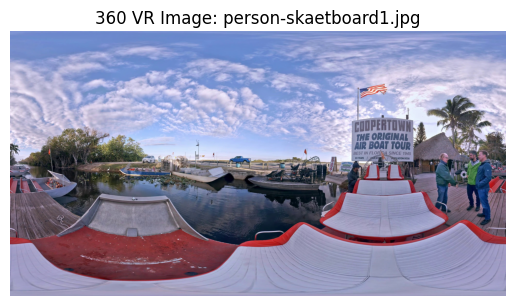

In [ ]:
pano_picture = f"./360-Dataset/360-Dataset/images/{sample_images}.jpg"
result_picture = "."

# ls 360-Dataset/360-Dataset/images

img = Image.open(pano_picture)

plt.imshow(img)
plt.title("360 VR Image: person-skaetboard1.jpg")
plt.axis('off')
plt.show()

In [ ]:
sample_images = "person-florida1910"

In [88]:
data_path = "./drive/MyDrive/360 CAC"
cat2imgkey = gen_query_images([sample_images], data_path)




100%|██████████| 1/1 [02:03<00:00, 123.44s/it]


(300, 300)
(300, 300)


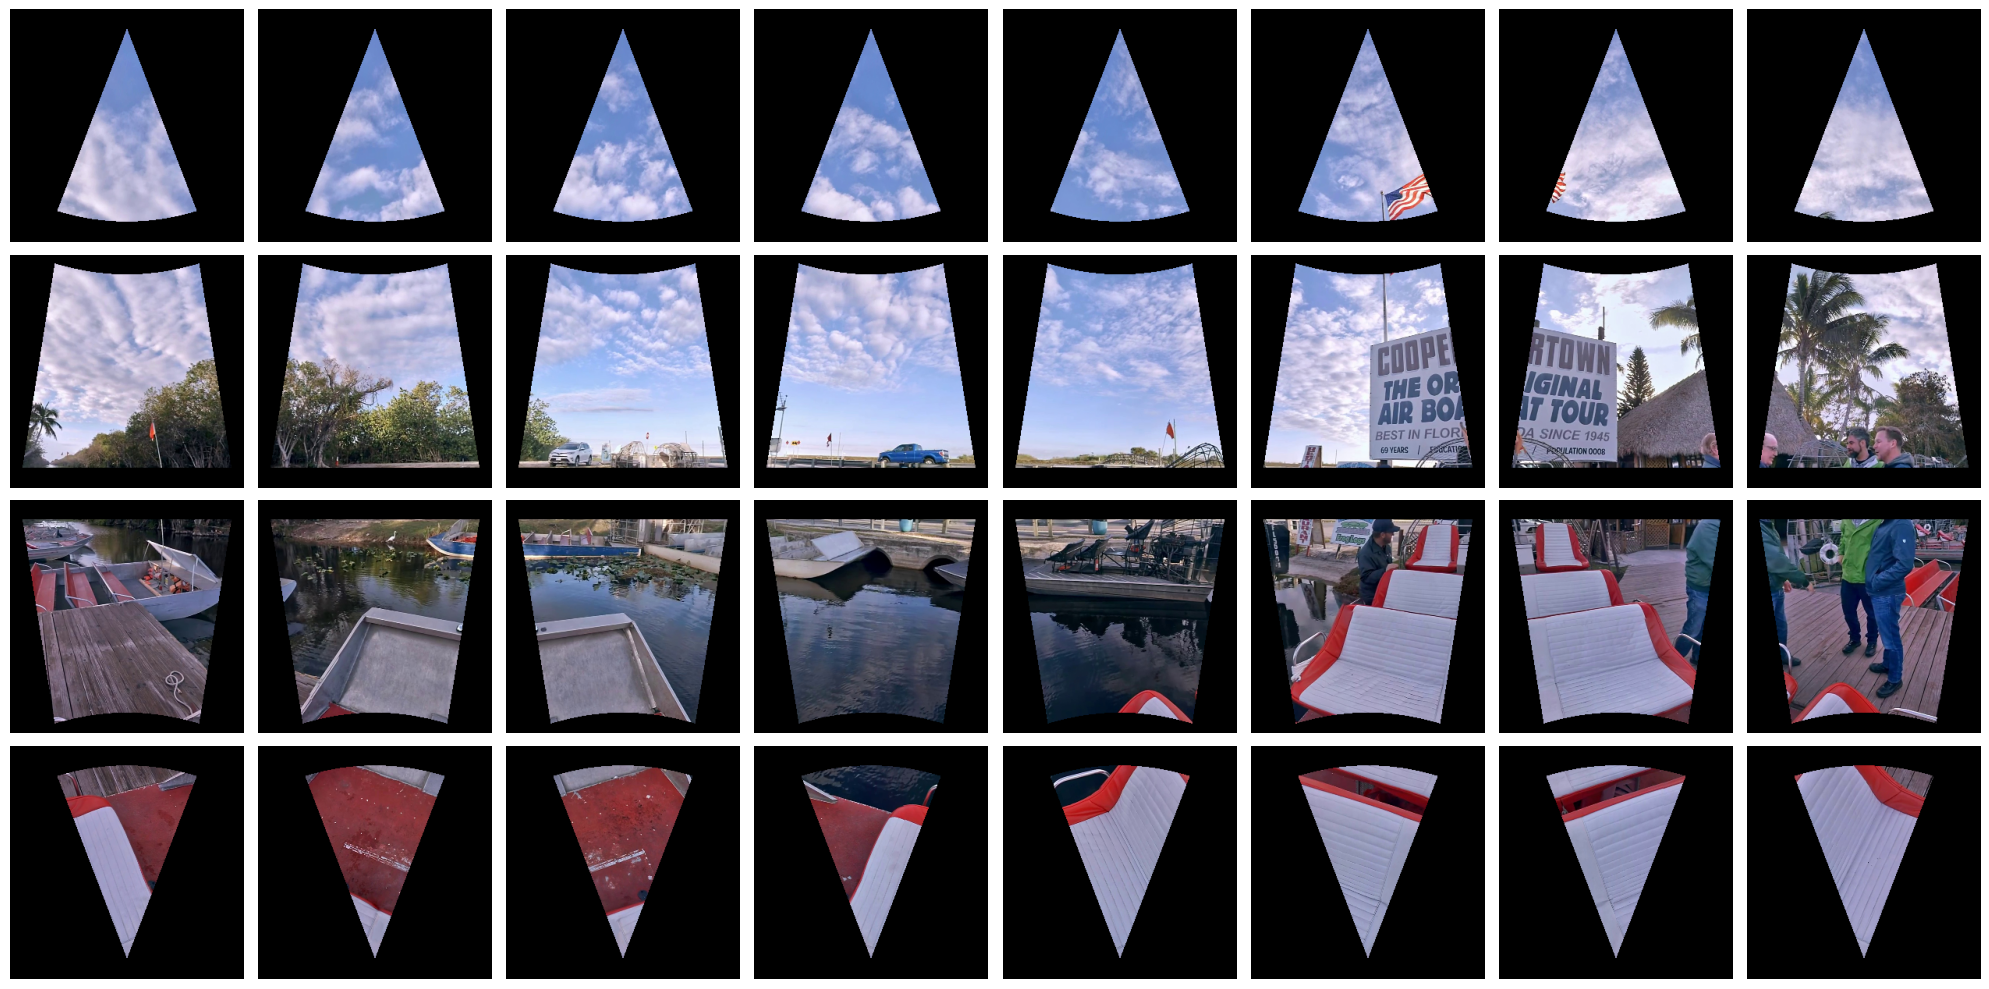

In [ ]:
rownum = 4
colnum = 8

fig, axes = plt.subplots(rownum, colnum, figsize=(20, 10))  # 6 列 12 欄，調整 figsize 可控制整體大小

query_images_path = os.path.join(data_path, f"query_images/boat/{sample_images}")
density_maps_path = os.path.join(data_path, f"density_maps/boat/{sample_images}")

images = []


images.append(img)

print(img.size)

img = Image.open(os.path.join(density_maps_path,"0.png")).convert("L")
images.append(img)
print(img.size)

img = Image.open(os.path.join(query_images_path,"0.png")).convert("RGB")
images.append(img)

img = Image.open(os.path.join(density_maps_path,"0.png")).convert("L")
images.append(img)

for i in range(rownum):
    for j in range(colnum):
        idx = i * colnum + j
        ax = axes[i, j]
        img = Image.open(os.path.join(query_images_path,f"{idx}.png")).convert("RGB")
        ax.imshow(img)
        ax.axis('off')  # 不顯示座標軸

plt.tight_layout()
plt.show()

# 儲存顏色

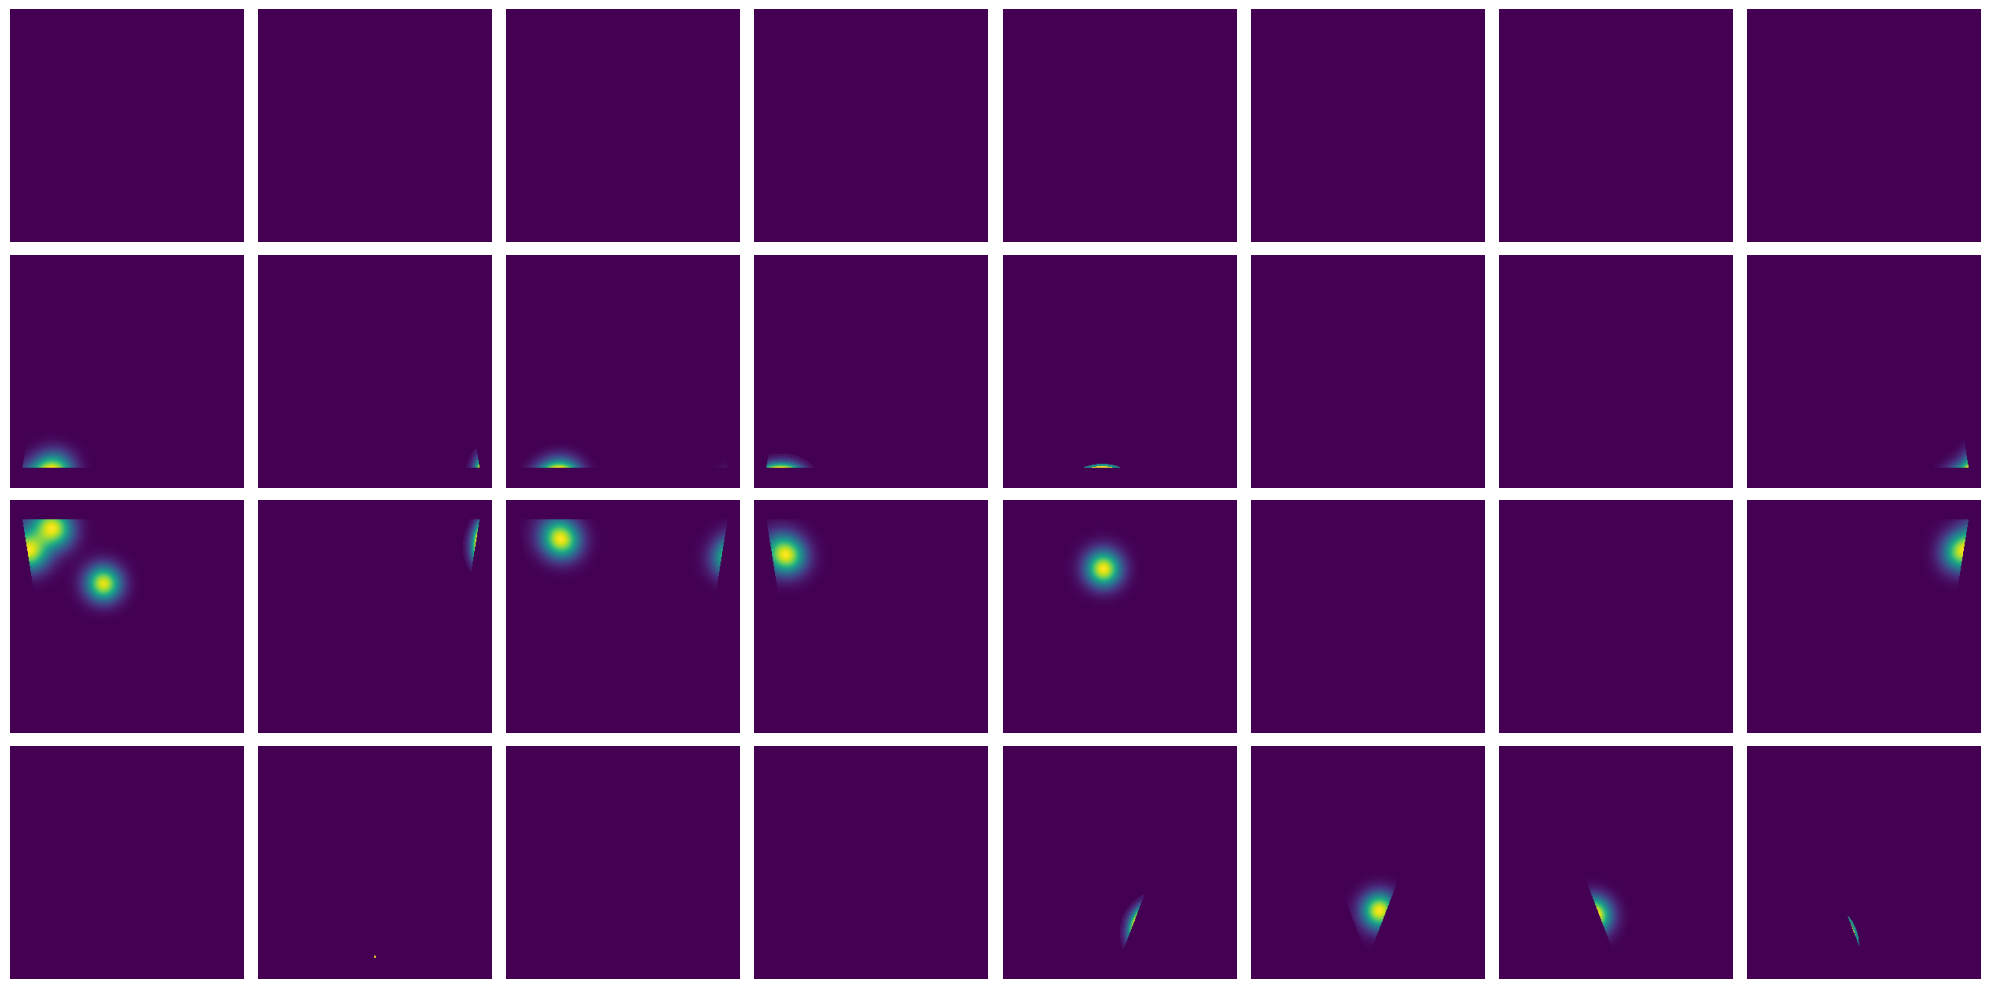

In [ ]:
rownum = 4
colnum = 8

fig, axes = plt.subplots(rownum, colnum, figsize=(20, 10))  # 6 列 12 欄，調整 figsize 可控制整體大小

density_maps_path = os.path.join(data_path, f"density_maps/boat/{sample_images}")

for i in range(rownum):
    for j in range(colnum):
        idx = i * colnum + j
        ax = axes[i, j]
        img = Image.open(os.path.join(density_maps_path,f"{idx}.png")).convert("L")
        ax.imshow(img)
        ax.axis('off')  # 不顯示座標軸

plt.tight_layout()
plt.show()

# 儲存顏色

In [ ]:
cat2refnum ,catrefnum2scat = gen_refference_images([sample_images],cat2imgkey,data_path)


100%|██████████| 1/1 [00:41<00:00, 41.21s/it]


In [ ]:
print(cat2imgkey)
print(cat2refnum)
print(catrefnum2scat)

{'boat': ['person-florida1910']}
{'boat': [0, 1, 2, 3], 'car': [0, 1], 'person': [0, 1, 2, 3]}
{'boat': {'0': 'boat', 1: 'boat', 2: 'boat', 3: 'boat'}, 'car': {'0': 'boat', 1: 'boat'}, 'person': {'0': 'boat', 1: 'boat', 2: 'boat', 3: 'boat'}}


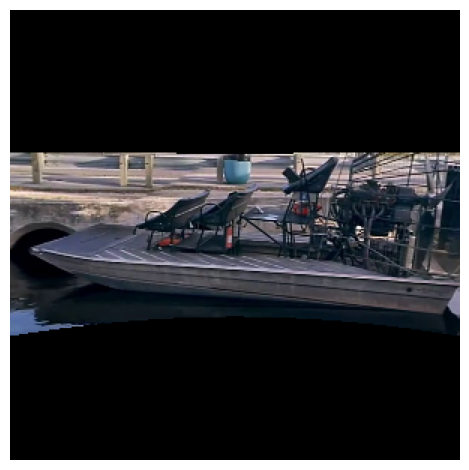

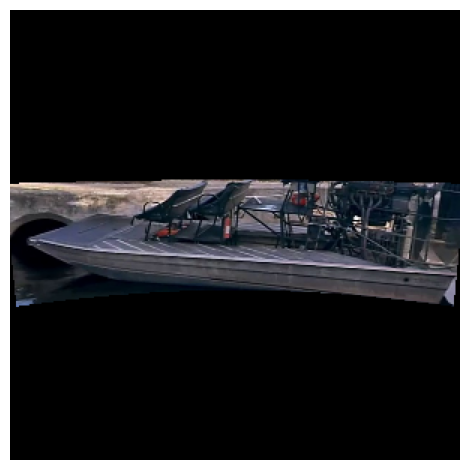

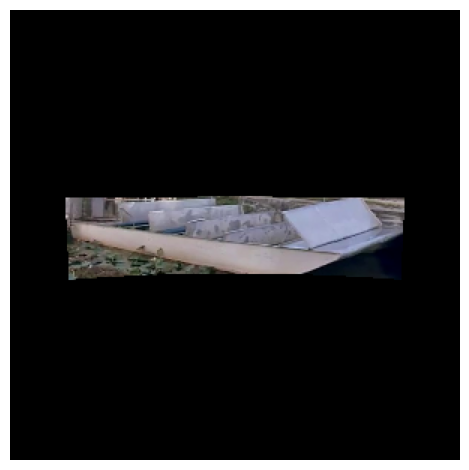

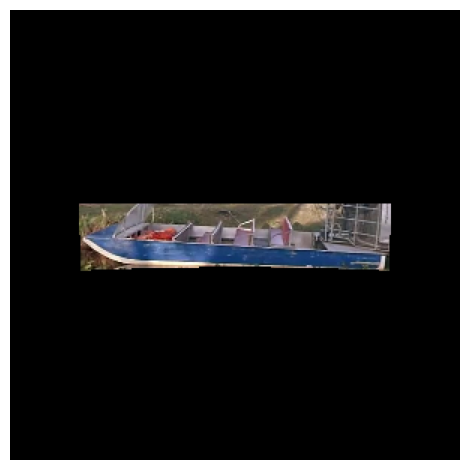

In [ ]:
image_num = 10

refference_images_path = os.path.join(data_path, f"refference_images/boat")

for i in range(image_num):
    if i > 3 :
      break
    img = Image.open(os.path.join(refference_images_path,f"{i}.png")).convert("RGB")
    plt.imshow(img)
    plt.axis('off')  # 不顯示座標軸
    plt.tight_layout()
    plt.show()





# 儲存顏色

In [ ]:
data_path = "./drive/MyDrive/360 CAC"
cat2imgkey, cat2refnum, catrefnum2scat = parse_xml(imgkey, data_path)

# query 約 30 分鐘, 1 GB
# refference 約 17 分鐘, 100 MB


already have cat2imgkey.pkl, so we will not project again
already have cat2refnum.pkl, so we will not project again


In [ ]:
# print([(k,v[:5]) for k, v in cat2imgkey.items()][:5])


print(f"# query img of each cat : {[(k,len(v)) for k, v in cat2imgkey.items()]}")


# print([(k,v[:5]) for k, v in cat2refnum.items()][:5])
print(f"# ref img of each cat : {[(k,len(v)) for k, v in cat2refnum.items()]}")

qualified_pano_num = 0
for k, v in cat2imgkey.items():
  qualified_pano_num += len(v)

print(f"after crowd selection, # of panorama = {qualified_pano_num}")


# query img of each cat : [('boat', 54), ('person', 300), ('penguin', 8), ('car', 100), ('sign', 45), ('dog', 2), ('hyaenidae', 1)]
# ref img of each cat : [('boat', 783), ('person', 3191), ('penguin', 90), ('car', 1618), ('sign', 646), ('dog', 18), ('hyaenidae', 5)]
after crowd selection, # of panorama = 510


In [ ]:
!git clone https://github.com/SinicaGroup/Class-agnostic-Few-shot-Object-Counting.git
!mv Class-agnostic-Few-shot-Object-Counting/* .

Cloning into 'Class-agnostic-Few-shot-Object-Counting'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 181 (delta 86), reused 25 (delta 2), pack-reused 19 (from 1)
Receiving objects: 100% (181/181), 70.60 MiB | 32.26 MiB/s, done.
Resolving deltas: 100% (87/87), done.


In [ ]:
####  coco.py

""""
crop training data，做成 refference data蒐集五百張，蒐集五百張


cat_path : ./images/crop/[category_id] => 儲存每個 category
./images/crop/[category_id]/[bbox_id].png => crop 後的照片



cat_instances = {
  category_id : [
    bbox_id,
    ...
  ],
  ...
}
並且放到 crop.json 中

""""


import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
from pycocotools.coco import COCO
import os
import cv2
import scipy.ndimage
import json

imgs_mean = [0.485, 0.456, 0.406]
imgs_std = [0.229, 0.224, 0.225]

cv2.setNumThreads(0) # disable multithread to avoid deadlocks

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


# 小心 refference
# 修整 density map

class CountingkDataset(Dataset):

    def __init__(self, config,dataset_type, cat2imgkey, cat2refnum folds=[0,1,2]):
        super(CountingkDataset, self).__init__()
        self.config = config
        self.dataset_type = dataset_type
        self.cat2imgkey = cat2imgkey
        self.cat2refnum = cat2refnum



        """
          training category 分四類 0 1 2 3 0 1 2 3
          3 是 testing 其他 training

        """

        if dataset_type == "train":
          self.select_catIds = ['boat', 'person'] #354

        elif dataset_type == "val":
          self.select_catIds = ['sign', 'penguin'] #53

        elif dataset_type == "test":
          self.select_catIds = ['car', 'dog', 'hyaenidae'] #103

        # ('boat', 54), ('person', 300), ('penguin', 8), ('car', 100), ('sign', 45), ('dog', 2), ('hyaenidae', 1)

        # cat2imgkey, cat2refnum

        self.img2cat = {} # image : [category_ids, ...] (一張 image 可能有很多 categorys)
        self.select_imgIds = [] # 要五個 box 以上才會被選種

        for c in self.select_catIds:
            imgs = self.cat2imgkey(c)
            for i in imgs:
                self.img2cat[i] = c
                self.select_imgIds.append(i)

        self.query_transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256,256))
        ])

        self.reference_transform = transforms.ToTensor()

        self.length = len(self.select_imgIds)

    def __len__(self):
        return self.length

# img_detail_dict

    def __getitem__(self, idx):
        select_imgId = self.select_imgIds[idx]
        selected_cat = self.img2cat[select_imgId]
        query_images_path = f"./query_images/{selected_cat}/{select_imgId}"
        image_paths = glob.glob(f"./query_images/{selected_cat}/{select_imgId}/*.png")
        query_images_tensor = []
        for path in image_paths:
          filename = os.path.basename(path)
          img = cv2.imread(f"{query_images_path}/{filename}",cv2.IMREAD_COLOR)
          query_tensor = self.generate_query_tensor(img)
          query_images_tensor.append(query_tensor)


        references_tensor = self.generate_references_tensor(selected_cat)

        target_densemap_tensor = self.get_target_densemap(img_obj,selected_cat)

        return query_images_tensor, references_tensor, target_densemap_tensor

# img2cat


    def generate_query_tensor(self, img):
        img_size = img.shape
        max_img_size = max(img_size[0],img_size[1])
        ph = int((max_img_size - img_size[0])/2)
        pw = int((max_img_size - img_size[1])/2)

        pad_img = np.pad(img,((ph,ph),(pw,pw),(0,0)))
        pad_img = cv2.cvtColor(pad_img,cv2.COLOR_BGR2RGB)
        query_tensor = self.query_transforms(pad_img)

        return query_tensor



    def generate_references_tensor(self,select_catId,k=5):
        """

          self.cat_instances = {
            category_id : [
              bbox_id,
              ...
            ],
            ...
          }

        """

        select_reference_imgIds = np.random.choice(self.cat2imgkey[str(select_catId)],k,True)

        references_tensor = []

        refference_path = f"./refference_images/{select_catId}"

        for ref_id in select_reference_imgIds:
            crop_img = cv2.imread(os.path.join(refference_path,f'{ref_id}.png'),cv2.IMREAD_COLOR)

            crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)

            crop_tensor = self.reference_transform(crop_img)

            references_tensor.append(crop_tensor)
        reference_concat = torch.stack(references_tensor, 0) # k * tensor_lenth matrix
        return reference_concat

    def get_target_densemap(self, img_obj, select_catId):

        ### 給予一群 1 點為中心，投影至平面為 query，求這些投影點(像素)的 density 值
        # 在 query image 時就實作


        max_img_size = max(img_obj['height'],img_obj['width'])
        scale_ratio = 256 / max_img_size
        ph = (max_img_size - img_obj['height']) /2
        ph = ph * scale_ratio
        pw = (max_img_size - img_obj['width']) /2
        pw = pw * scale_ratio

        density = np.zeros((256,256))

        anno_ids = self.coco_api.getAnnIds(int(img_obj['id']),select_catId,iscrowd=False)
        anno_objs = self.coco_api.loadAnns(anno_ids)

        ptx = []
        pty = []
        for anno_obj in anno_objs:
            bbox = np.array(anno_obj['bbox'])
            bbox = bbox * scale_ratio
            x = bbox[0] + pw
            y = bbox[1] + ph
            w = bbox[2]
            h = bbox[3]

            center_x = int(x+w/2)
            center_y = int(y+h/2)

            ptx.append(center_x)
            pty.append(center_y)


        density[pty,ptx] = 1
        density = scipy.ndimage.gaussian_filter(density, sigma=(5,5), mode='constant')
        density = torch.from_numpy(density.astype('float32'))

        return density.unsqueeze(0)


# if __name__ == "__main__":
#     from torch.utils.data import DataLoader
#     import argparse
#     # import visdom
#     # viz = visdom.Visdom()

#     torch.manual_seed(0)
#     torch.cuda.manual_seed_all(0)
#     np.random.seed(0)

#     config = argparse.Namespace()
#     config.data = argparse.Namespace()
#     config.data.data_path = '/home/Hacker_Davinci/Desktop/coco'
#     d = CountingkDataset(config)
#     data_loader = DataLoader(d,1,shuffle=True)

#     print("Total:", len(data_loader))
#     it = iter(data_loader)
#     for i in range(10):
#         q,r,den = next(it)

#         plt.imshow(den[0, 0].cpu().numpy())
#         plt.savefig(f"/home/Hacker_Davinci/Desktop/Dataset/CFOCNet_3layers/CFOCNet_refector/test_dataloader/{i}_density.png")


#         torchvision.utils.save_image(q, f"/home/Hacker_Davinci/Desktop/Dataset/CFOCNet_3layers/CFOCNet_refector/test_dataloader/{i}_query.png")
#         # plt.imshow(q[0, 0].cpu().numpy())
#         # plt.savefig(f"/home/Hacker_Davinci/Desktop/Dataset/CFOCNet_3layers/CFOCNet_refector/test_dataloader/{i}_query.png")

#         # plt.imshow(r[0].cpu().numpy())
#         # plt.savefig(f"/home/Hacker_Davinci/Desktop/Dataset/CFOCNet_3layers/CFOCNet_refector/test_dataloader/{i}_reference.png")
#         torchvision.utils.save_image(r[0], f"/home/Hacker_Davinci/Desktop/Dataset/CFOCNet_3layers/CFOCNet_refector/test_dataloader/{i}_reference.png")

#         # viz.heatmap(torch.flip(den.squeeze(),[0]))
#         # viz.images(torch.clamp(q,0,1))
#         # viz.images(torch.clamp(r.squeeze(),0,1))







In [ ]:
import os
import numpy as np
from data.coco import CountingkDataset
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import torch
import logging
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from model.loss import my_loss
from model.CFOCNet import CFOCNet



class Runner:
    def __init__(self,args,config):
        self.args= args
        self.config= config
        self.args.log_sample_path = os.path.join(args.log_path, 'samples')
        os.makedirs(self.args.log_sample_path, exist_ok=True)

    def train(self):

        # Import the dataset
        dataset = CountingkDataset(self.config,'train') # cat2imgkey, cat2refnum
        data_loader = DataLoader(dataset,self.config.train.batch_size,shuffle=True,pin_memory=True,num_workers=self.config.train.num_workers)
        print("dataset length ", len(dataset))

        net = CFOCNet()

        net.to(self.config.device)

        optimizer = optim.Adam(net.parameters(),lr=self.config.optimizer.lr)

        plt.gca().invert_yaxis() # because the direction of y axis in heatmap is different from images


        for epoch in range(self.config.train.epochs):
            for i, sample in enumerate(data_loader):
                optimizer.zero_grad()

                queries = sample[0].to(self.config.device)
                references = sample[1].to(self.config.device)
                target = sample[2].to(self.config.device)

                net.train()

                # for

                FS = net(queries,references)
                loss, ssim_loss = my_loss(FS,target,self.config)

                loss.backward()
                optimizer.step()

                print(f"Loss: {loss / self.config.train.batch_size}, SSIM Loss: {ssim_loss / self.config.train.batch_size}")

#                 if i % 1000 == 0:
#                     net.eval()
#                     with torch.no_grad():
#                         predict = net(queries,references)

#                         # Save query image
#                         save_image(queries[0], os.path.join(self.config.train.result_path, f"Epoch_{epoch}_number_{i*self.config.train.batch_size}_query.png"))

#                         # Save reference images
#                         save_image(references[0], os.path.join(self.config.train.result_path, f"Epoch_{epoch}_number_{i*self.config.train.batch_size}_reference.png"))

#                         # Save target images
#                         plt.imshow(target[0,0].cpu().numpy())
#                         plt.title(f'target sum : {np.sum(target[0,0].cpu().numpy())}')
#                         plt.savefig(os.path.join(self.config.train.result_path, f"Epoch_{epoch}_number_{i*self.config.train.batch_size}_target.png"))

#                         # Save predict images
#                         plt.imshow(predict[0,0].cpu().numpy())
#                         plt.title(f'predict sum : {np.sum(predict[0,0].cpu().numpy())}')
#                         plt.savefig(os.path.join(self.config.train.result_path, f"Epoch_{epoch}_number_{i*self.config.train.batch_size}_predict.png"))

#                         logging.info(f'Epoch {epoch} Number {i*self.config.train.batch_size} picture loss:{loss.item()/self.config.train.batch_size}')
#                         logging.info(f'target sum: {np.sum(target[0,0].cpu().numpy())}, predict sum: {np.sum(predict[0,0].cpu().numpy())}')


            torch.save(net.state_dict(),os.path.join(self.args.log_path,f'model_epoch_{epoch}.pth'))

    def test(self):

        net = CFOCNet()

        net.to(self.config.device)

        checkpoint = torch.load(self.config.eval.checkpoint)
        net.load_state_dict(checkpoint)
        net.eval()


        dataset = CountingkDataset(self.config,'train',[3]) # cat2imgkey, cat2refnum
        data_loader = DataLoader(dataset,self.config.train.batch_size,pin_memory=True,num_workers=self.config.train.num_workers)

        mae_sum = 0
        mse_sum = 0

        count = len(dataset)

        with torch.no_grad():
            for i, sample in enumerate(data_loader):

                queries = sample[0].to(self.config.device)
                references = sample[1].to(self.config.device)
                target = sample[2].to(self.config.device)

                predict = net(queries,references)

                logging.info(f'target num: {torch.sum(target).item()}, predict num: {torch.sum(predict).item()}')

                target_num = torch.sum(target).item()
                predict_num = torch.sum(predict).item()

                mae_sum += abs(target_num-predict_num)
                mse_sum += abs(target_num-predict_num) **2

#                 if self.config.eval.sample:

#                     os.makedirs(os.path.join(self.config.eval.image_folder,'bad'),exist_ok=True)
#                     os.makedirs(os.path.join(self.config.eval.image_folder,'good'),exist_ok=True)

#                     if abs(target_num - predict_num) >=50:

#                         save_image(queries[0], os.path.join(self.config.eval.image_folder, f'bad/{i}_query_bad.png'))
#                         # grids = make_grid(references)
#                         save_image(references[0], os.path.join(self.config.eval.image_folder, f'bad/{i}_ref_bad.png'))

#                         plt.imshow(predict[0,0].cpu().numpy())
#                         plt.title(f'predict sum = {predict_num}')
#                         plt.savefig(os.path.join(self.config.eval.image_folder, f'bad/{i}_predict_bad.png'))

#                         plt.imshow(target[0,0].cpu().numpy())
#                         plt.title(f'target sum = {target_num}')
#                         plt.savefig(os.path.join(self.config.eval.image_folder, f'bad/{i}_target_bad.png'))

#                     if abs(target_num - predict_num)<=20:

#                         save_image(queries[0],os.path.join(self.config.eval.image_folder, f'good/{i}_query_good.png'))
#                         # grids = make_grid(references)
#                         save_image(references[0],os.path.join(self.config.eval.image_folder, f'good/{i}_ref_good.png'))

#                         plt.imshow(predict[0,0].cpu().numpy())
#                         plt.title(f'predict sum = {predict_num}')
#                         plt.savefig(os.path.join(self.config.eval.image_folder, f'good/{i}_predict_good.png'))

#                         plt.imshow(target[0,0].cpu().numpy())
#                         plt.title(f'target sum = {target_num}')
#                         plt.savefig(os.path.join(self.config.eval.image_folder, f'good/{i}_target_good.png'))


        print(f'mae = {mae_sum/count}')
        print(f'mse = {mse_sum/count}')

In [ ]:
import torch
import logging
import os
import sys
import shutil
import numpy as np
import argparse
import yaml #
import copy
import traceback
from runner import Runner

def parse_args_and_config():

    parser = argparse.ArgumentParser(description=globals()['__doc__'])

    parser.add_argument('--config', type=str, required=True,  help='Path to the config file')
    parser.add_argument('--seed', type=int, default=0, help='Random seed')
    parser.add_argument('--exp', type=str, default='exp', help='Path for saving running related data.')
    parser.add_argument('--doc', type=str, required=True, help='A string for documentation purpose. '
                                                               'Will be the name of the log folder.')
    parser.add_argument('--comment', type=str, default='', help='A string for experiment comment')
    parser.add_argument('--verbose', type=str, default='info', help='Verbose level: info | debug | warning | critical')
    parser.add_argument('--train', action='store_true', help='Whether to train the model')
    parser.add_argument('--test', action='store_true', help='Whether to test the model')
    parser.add_argument('--sample', action='store_true', help='Whether to produce samples from the model')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('-i', '--image_folder', type=str, default='images', help="The folder name of samples")

    args = parser.parse_args()

    args.log_path = os.path.join(args.exp, 'logs', args.doc)

    # parse config file
    with open(os.path.join('configs', args.config), 'r') as f:
        config = yaml.load(f,yaml.CLoader)
    new_config = dict2namespace(config)

    if not args.test: # train
        if not args.resume_training and not args.sample:
            if os.path.exists(args.log_path):
                overwrite = False
                response = input("Folder already exists. Overwrite? (Y/N)") # 是否要覆蓋 log 檔
                if response.upper() == 'Y':
                    overwrite = True

                if overwrite:
                    shutil.rmtree(args.log_path)
                    os.makedirs(args.log_path)
            else:
                os.makedirs(args.log_path)

            with open(os.path.join(args.log_path, 'config.yml'), 'w') as f:
                yaml.dump(new_config, f, default_flow_style=False)

        # setup logger
        level = getattr(logging, args.verbose.upper(), None)
        if not isinstance(level, int):
            raise ValueError('level {} not supported'.format(args.verbose))

        handler1 = logging.StreamHandler()
        handler2 = logging.FileHandler(os.path.join(args.log_path, 'stdout.txt'))
        formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
        handler1.setFormatter(formatter)
        handler2.setFormatter(formatter)
        logger = logging.getLogger()
        logger.addHandler(handler1)
        logger.addHandler(handler2)
        logger.setLevel(level)

    else: # test
        level = getattr(logging, args.verbose.upper(), None)
        if not isinstance(level, int):
            raise ValueError('level {} not supported'.format(args.verbose))

        handler1 = logging.StreamHandler()
        formatter = logging.Formatter('%(levelname)s - %(filename)s - %(asctime)s - %(message)s')
        handler1.setFormatter(formatter)
        logger = logging.getLogger()
        logger.addHandler(handler1)
        logger.setLevel(level)

        if args.sample: # evaluation sample
            os.makedirs(os.path.join(args.exp, 'image_samples'), exist_ok=True)
            args.image_folder = os.path.join(args.exp, 'image_samples', args.image_folder)
            if not os.path.exists(args.image_folder):
                os.makedirs(args.image_folder)
            else:
                overwrite = False
                response = input("Image folder already exists. Overwrite? (Y/N)")
                if response.upper() == 'Y':
                    overwrite = True

                if overwrite:
                    shutil.rmtree(args.image_folder)
                    os.makedirs(args.image_folder)
                else:
                    print("Output image folder exists. Program halted.")
                    sys.exit(0)

    # add device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    logging.info("Using device: {}".format(device))
    new_config.device = device

    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)

    return args, new_config

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

def main():

    sys.argv = [
      '',  # sys.argv[0] 通常是程式名稱，可以留空字串
      '--config', 'config.yaml',
      '--doc', 'traininglog',
      # '--train',
      '--test',
      # '--verbose', 'info',
      # '--seed', '123',
      # '--exp', 'exp_folder',
      # '--comment', 'this is a test',
      # '--image_folder', 'images',
      # 加上其他你想啟用的 flag，例如 '--sample' '--test' '--resume_training'
    ]


    args, config = parse_args_and_config()
    logging.info("Writing log file to {}".format(args.log_path))
    logging.info("Exp comment = {}".format(args.comment))
    logging.info("Config =")
    print(">" * 80)
    config_dict = copy.copy(vars(config)) # vars
    print(yaml.dump(config_dict, default_flow_style=False))
    print("<" * 80)

    try:
        runner = Runner(args,config)
        if args.test:
            runner.test()
        elif args.train:
            runner.train()
        else:
            print("Add --test or --train in your command line or run.sh !")
    except:
        logging.error(traceback.format_exc())

    return 0


if __name__ == '__main__':
    main()


INFO:root:Using device: cpu
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,409 - Using device: cpu
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,409 - Using device: cpu
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,409 - Using device: cpu
INFO:root:Writing log file to exp/logs/traininglog
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,415 - Writing log file to exp/logs/traininglog
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,415 - Writing log file to exp/logs/traininglog
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,415 - Writing log file to exp/logs/traininglog
INFO:root:Exp comment = 
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,419 - Exp comment = 
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,419 - Exp comment = 
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,419 - Exp comment = 
INFO:root:Config =
INFO - ipython-input-11-3933855651.py - 2025-06-30 02:14:47,4

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
data: !!python/object:argparse.Namespace
  data_path: .
  num_references: 5
device: !!python/object/apply:torch.device
- cpu
eval: !!python/object:argparse.Namespace
  checkpoint: /home/Hacker_Davinci/Desktop/Open_Source/CFOCNet/ckpt/model.ckpt
  image_folder: /home/Hacker_Davinci/Desktop/Open_Source/CFOCNet/image_folder
  sample: true
optimizer: !!python/object:argparse.Namespace
  lr: 0.0001
train: !!python/object:argparse.Namespace
  batch_size: 12
  epochs: 5
  num_workers: 2
  references: 5
  result_path: ./CFOCNet/Result
  ssim_loss: 1.0e-05

<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
loading annotations into memory...
Done (t=26.50s)
creating index...
index created!
dataset length  40552


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loss: 983.1940307617188, SSIM Loss: 0.9999998211860657
Loss: 2245.589111328125, SSIM Loss: 1.0
Loss: 933.9127807617188, SSIM Loss: 1.0
Loss: 1672.5821533203125, SSIM Loss: 1.0
Loss: 1052.69921875, SSIM Loss: 1.0
Loss: 864.7279663085938, SSIM Loss: 1.0
Loss: 825.6889038085938, SSIM Loss: 1.0
Loss: 1013.5855102539062, SSIM Loss: 1.0
Loss: 735.1605834960938, SSIM Loss: 1.0
Loss: 387.4961853027344, SSIM Loss: 1.0
Loss: 336.5240783691406, SSIM Loss: 1.0
Loss: 286.1087341308594, SSIM Loss: 1.0
Loss: 512.3949584960938, SSIM Loss: 1.0
Loss: 633.1654663085938, SSIM Loss: 1.0
Loss: 323.3746643066406, SSIM Loss: 1.0
Loss: 254.6892852783203, SSIM Loss: 1.0
Loss: 266.8857727050781, SSIM Loss: 1.0
Loss: 389.9000244140625, SSIM Loss: 1.0
Loss: 336.359130859375, SSIM Loss: 1.0
Loss: 266.142578125, SSIM Loss: 1.0
Loss: 179.65907287597656, SSIM Loss: 1.0
Loss: 261.7568359375, SSIM Loss: 1.0
Loss: 292.5647888183594, SSIM Loss: 1.0
Loss: 248.77685546875, SSIM Loss: 1.0
Loss: 176.0298614501953, SSIM Loss: 

ERROR:root:Traceback (most recent call last):
  File "/tmp/ipython-input-11-3933855651.py", line 153, in main
    runner.train()
  File "/content/runner.py", line 46, in train
    FS = net(queries,references)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1750, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/model/CFOCNet.py", line 80, in forward
    input2, _ = self.sa_q2(q2)
                ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/mod

In [ ]:
### config.yaml


train:
  epochs: 5
  batch_size: 12
  # snapshot_freq: 1000
  # snapshot_sampling: true
  num_workers: 2
  ssim_loss: 1.0e-5
  references: 5
  result_path: ./CFOCNet/Result

data:
  data_path: .
  num_references: 5

optimizer:
  lr: 1.0e-4

eval:
  checkpoint: /home/Hacker_Davinci/Desktop/Open_Source/CFOCNet/ckpt/model.ckpt
  sample: true
  image_folder: /home/Hacker_Davinci/Desktop/Open_Source/CFOCNet/image_folder



config.yaml


In [ ]:
### model/CFOCNet.py

"""
  有 refference path, 也有 query path
"""

In [ ]:
training
validate
testing

